In [222]:
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.patches as mpatches

import seaborn as sb

In [ ]:
df = pd.read_csv("/home/austin/data/IPI/tiled_frequency_results/summarized_data.csv")
savedir = Path("/home/austin/data/IPI/tiled_frequency_results/summary_figures")

if not savedir.exists():
    savedir.mkdir()
df = df.drop(['Unnamed: 0'], axis=1)

archetypes = np.unique(df['archetype'])
arch_df = df[['sample','archetype']]

In [ ]:
cell_types = ['cd4_t_cell',
              'cd8_t_cell',
              'cdc1',
              'mac',
              'cd163_pos_haldr_neg']

In [ ]:
colors = ['#000000','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

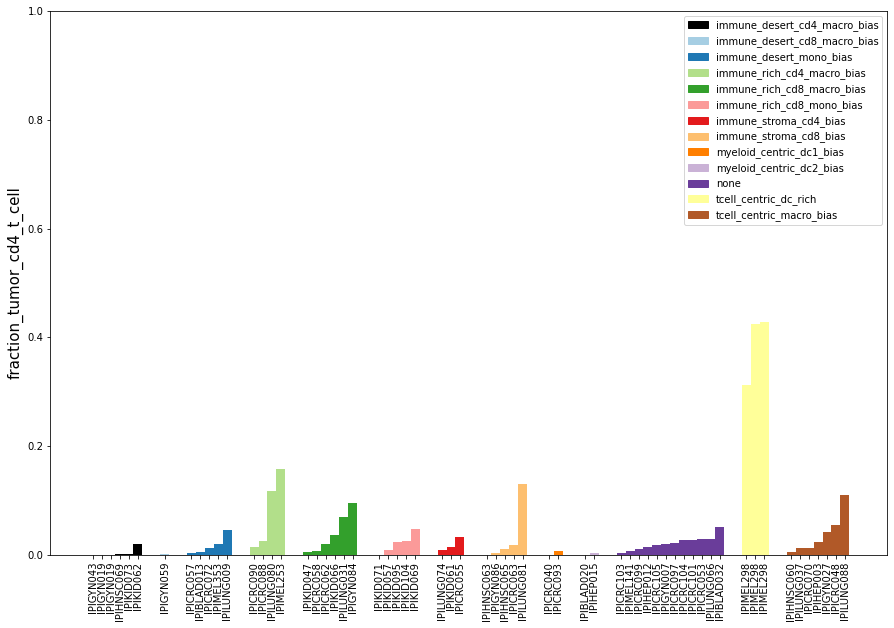

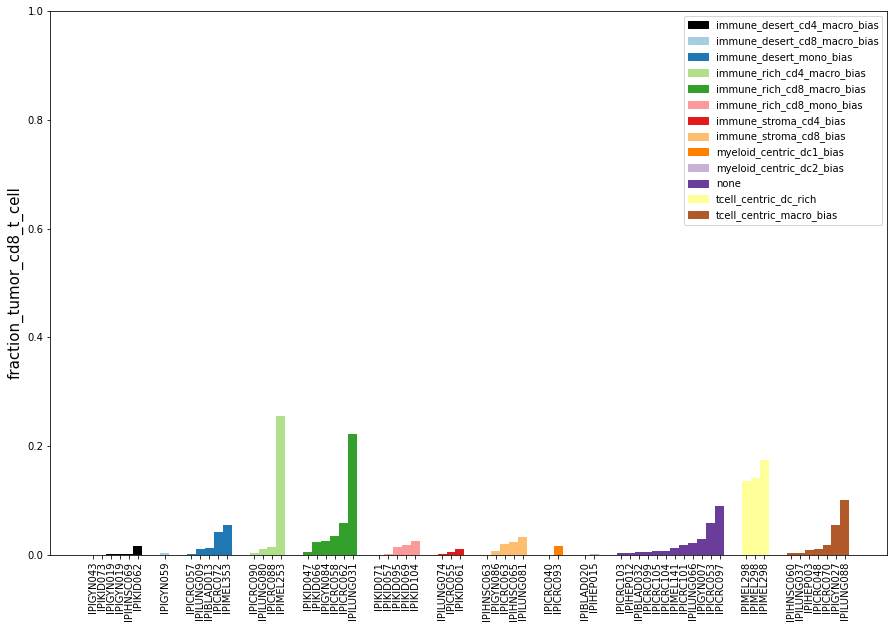

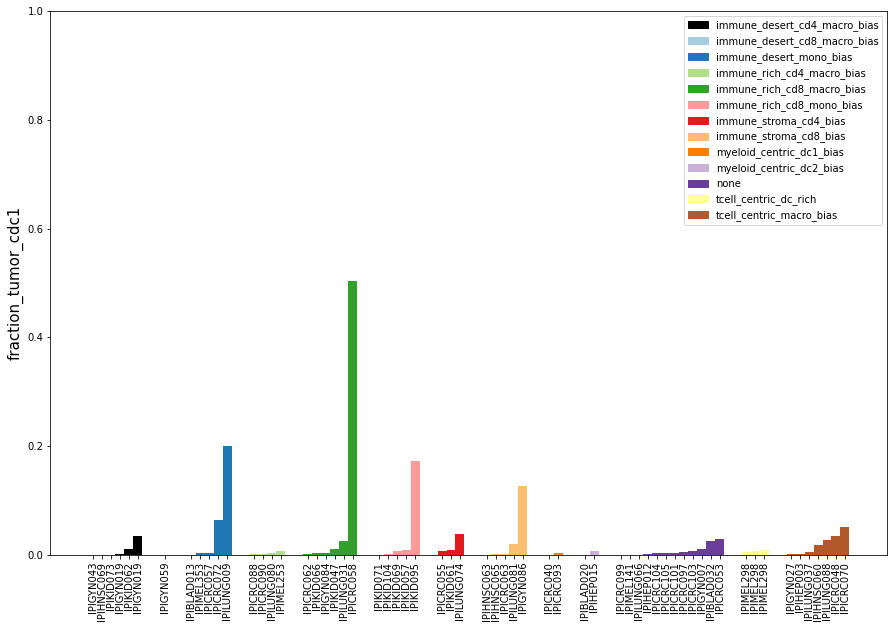

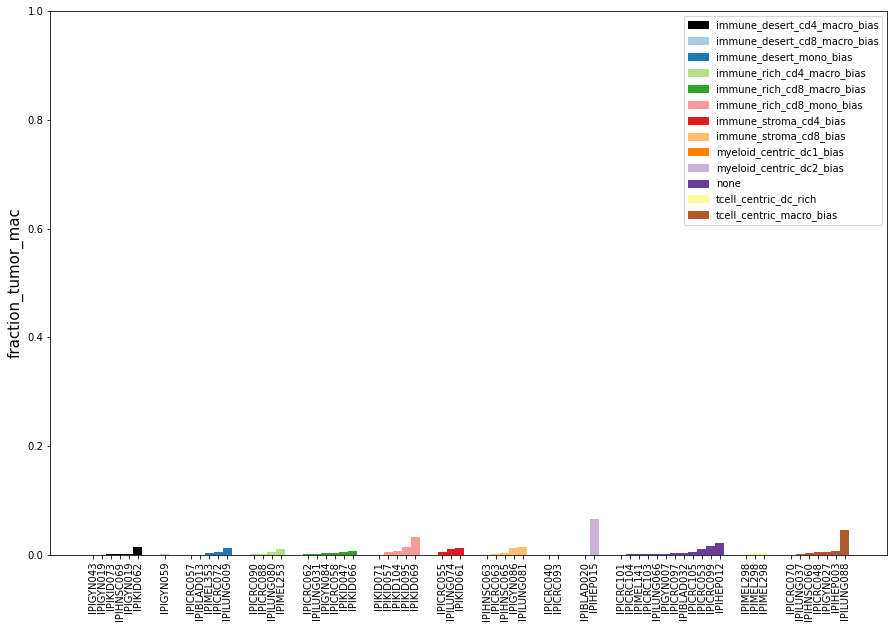

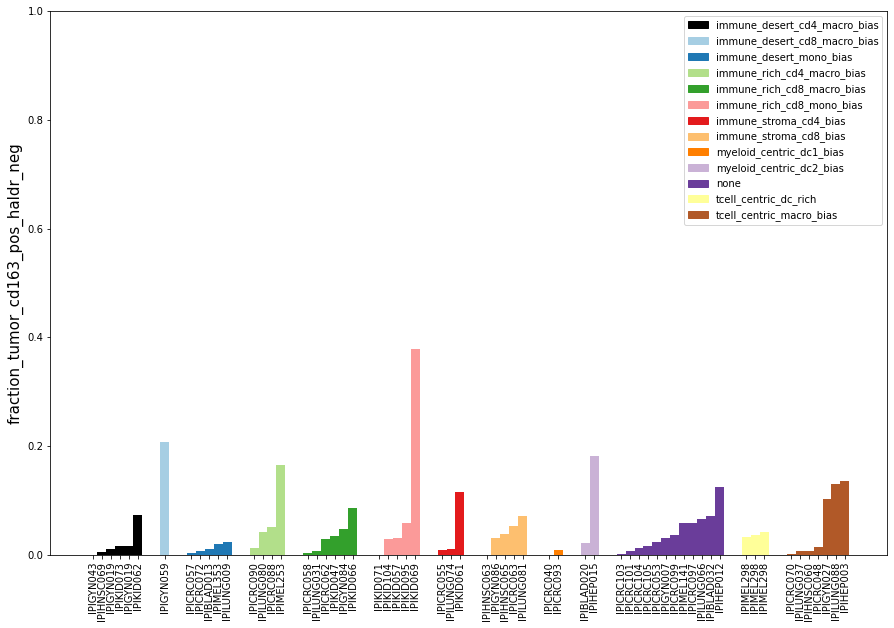

In [232]:
for ct1 in cell_types:
    #for ct2 in cell_types:
        
    #    if ct1==ct2: continue
        feature = "fraction_tumor_" + ct1
        
        try:
            plot_single_cell_type_feature(df, feature, savedir, colors, plot_type='sample', ylim=[0,1])
        except KeyError:
            pass

In [163]:
for ct1 in cell_types:
    for ct2 in cell_types:
        if ct1==ct2: continue
        
        try:
            df[ct1 + "_" + ct2 + "_interactions_norm"] = df[ct1 + "_" + ct2 + "_interactions_count"]/(df["count_"+ct1] + df["count_"+ct2])
        except KeyError:
            pass

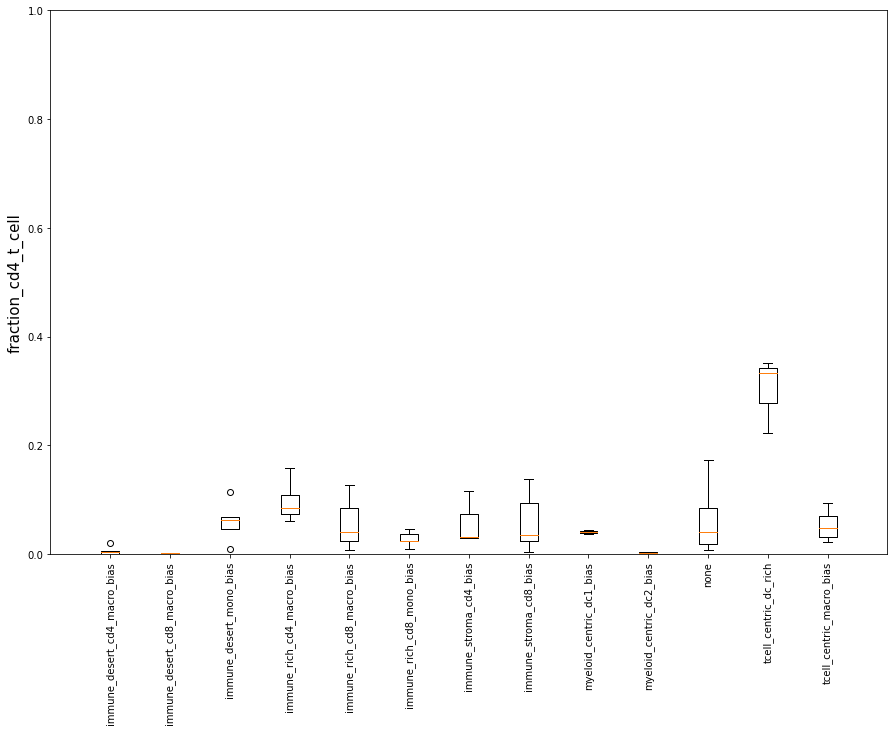

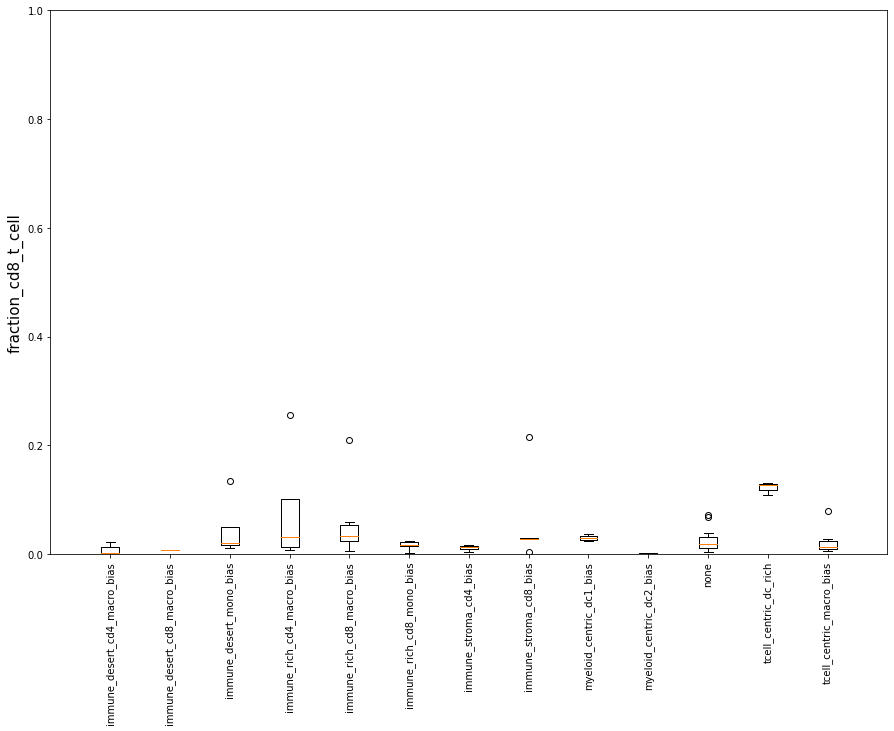

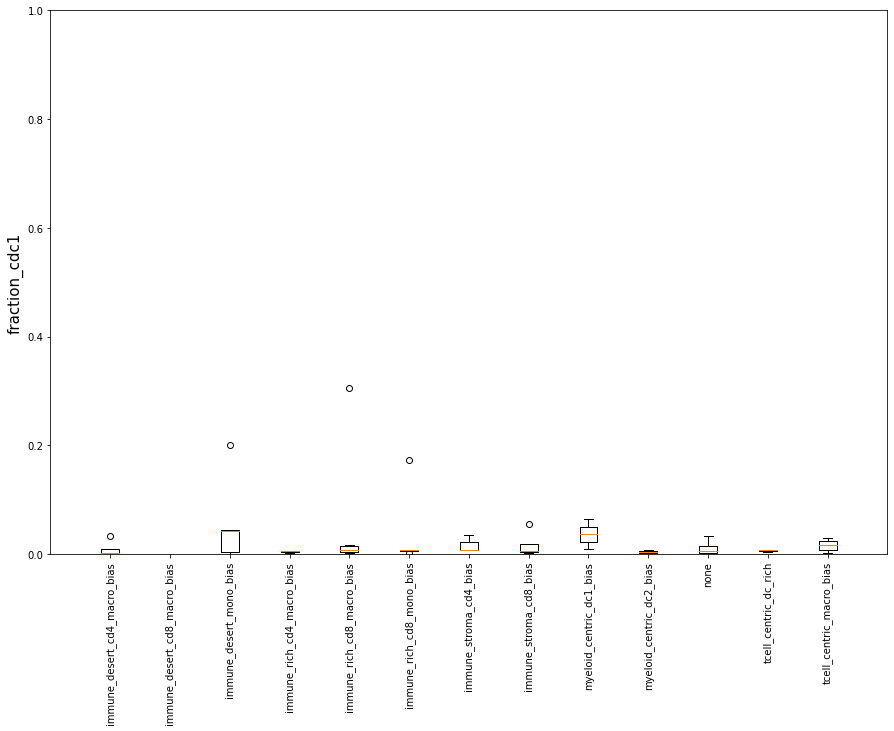

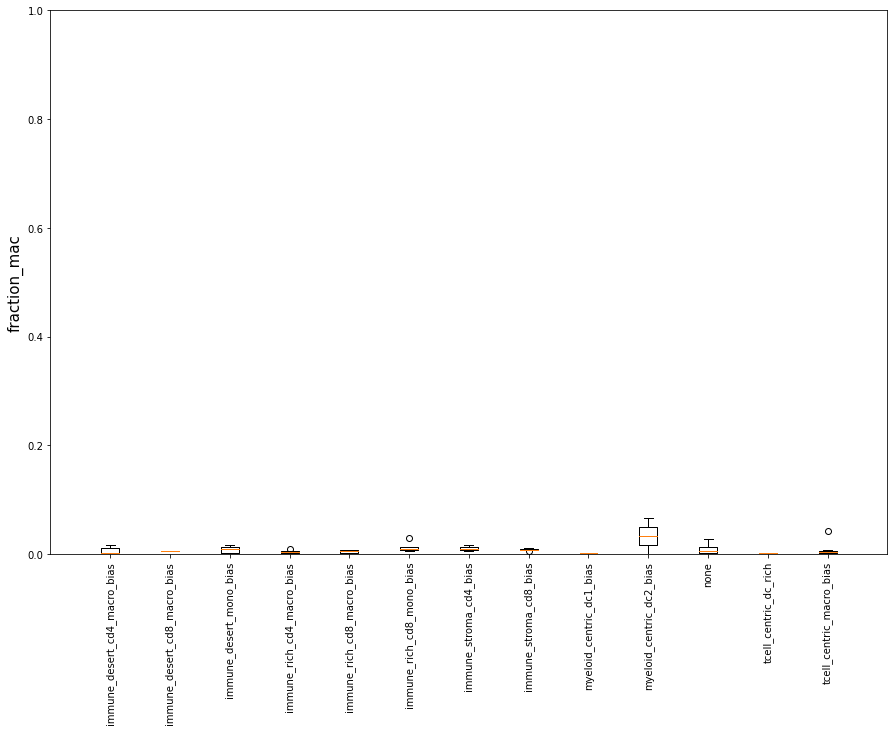

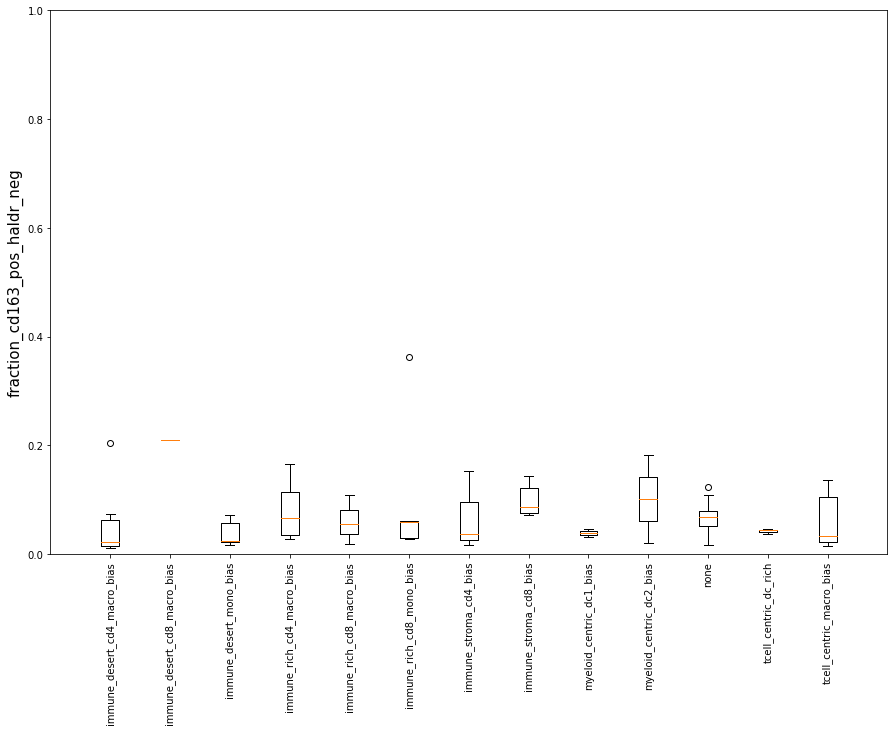

In [16]:
for ct1 in cell_types:
    #for ct2 in cell_types:
        
    #    if ct1==ct2: continue
        feature = "fraction_tumor_" + ct1
        
        try:
            plot_single_cell_type_feature(df, feature, savedir, colors, plot_type='archetype', ylim=[0,1])
        except KeyError:
            pass

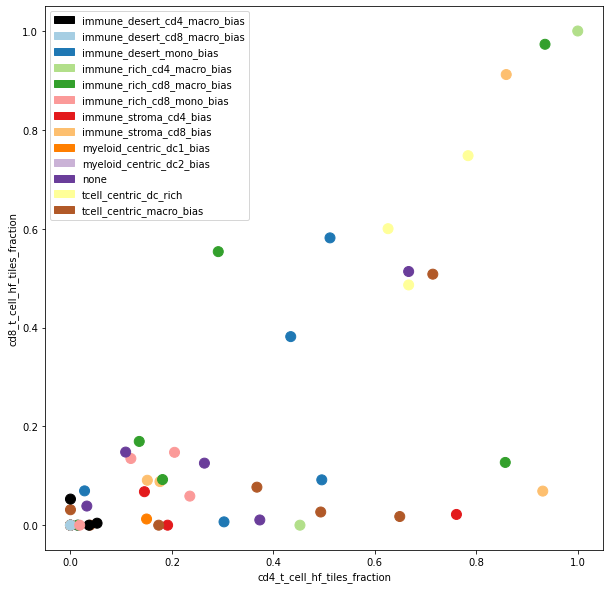

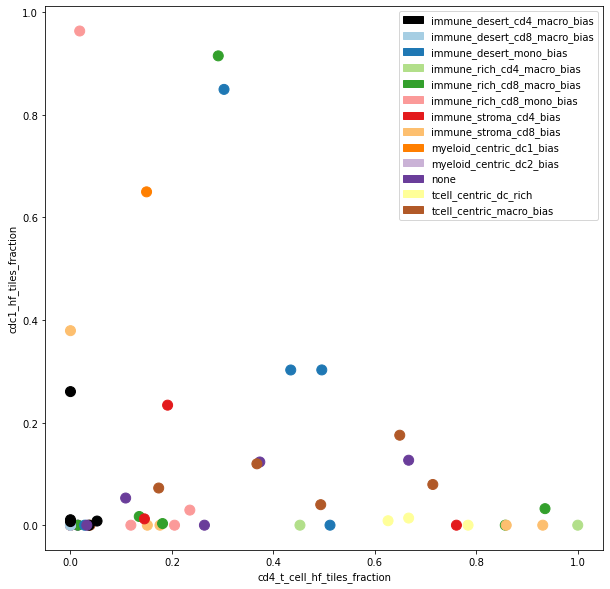

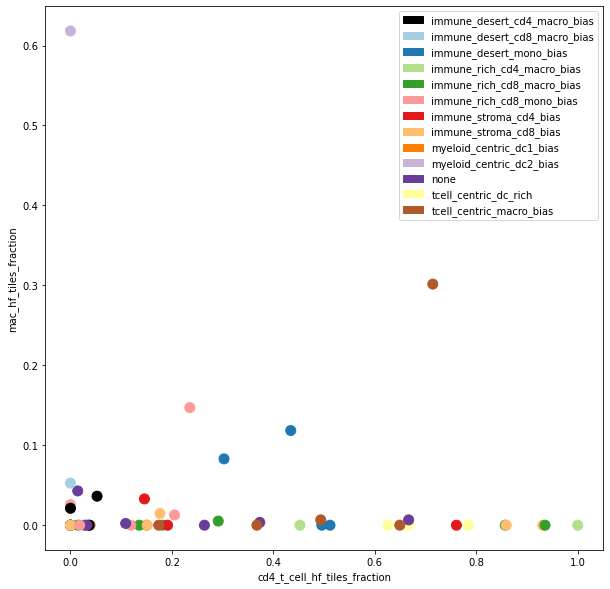

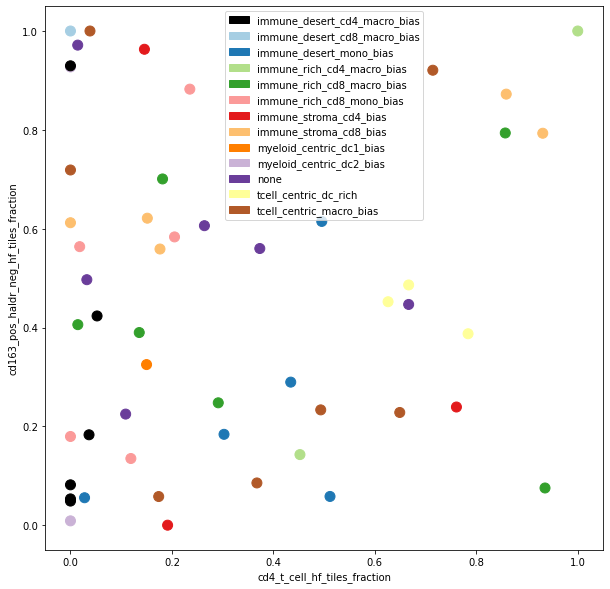

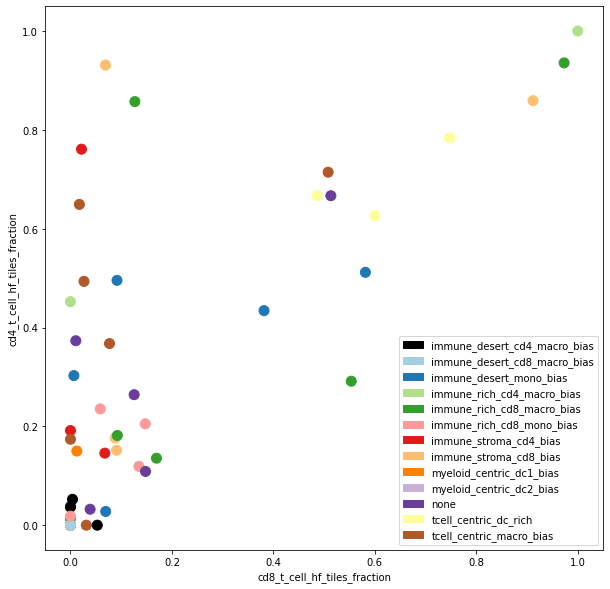

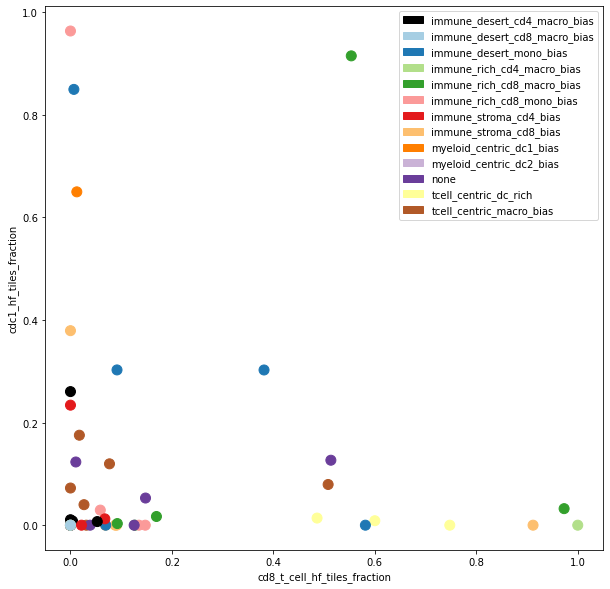

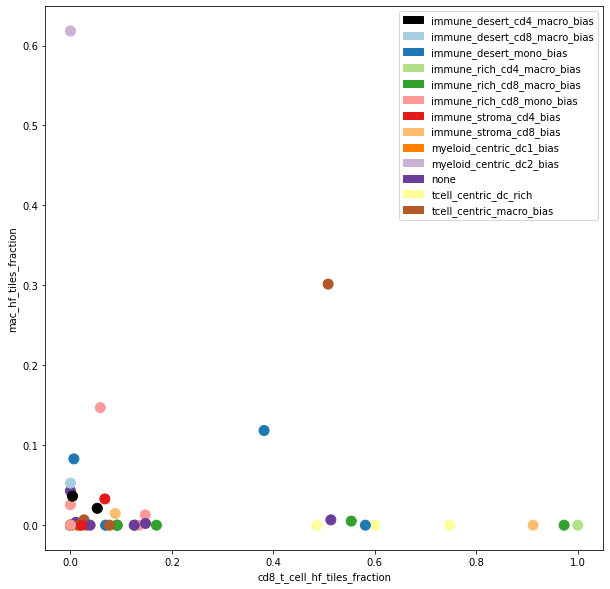

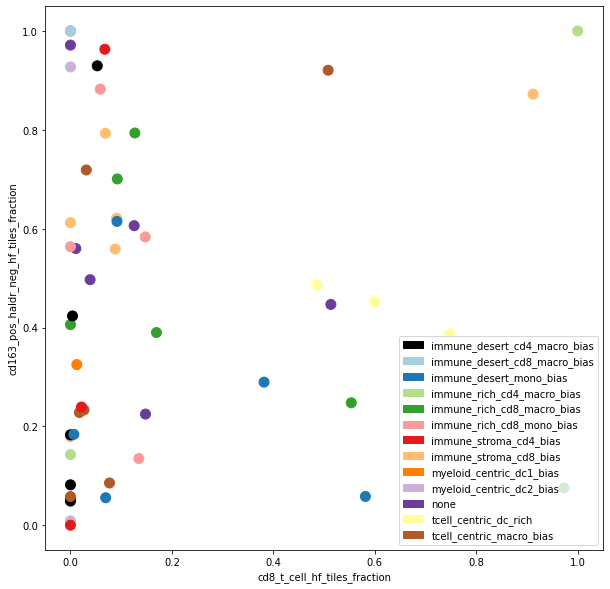

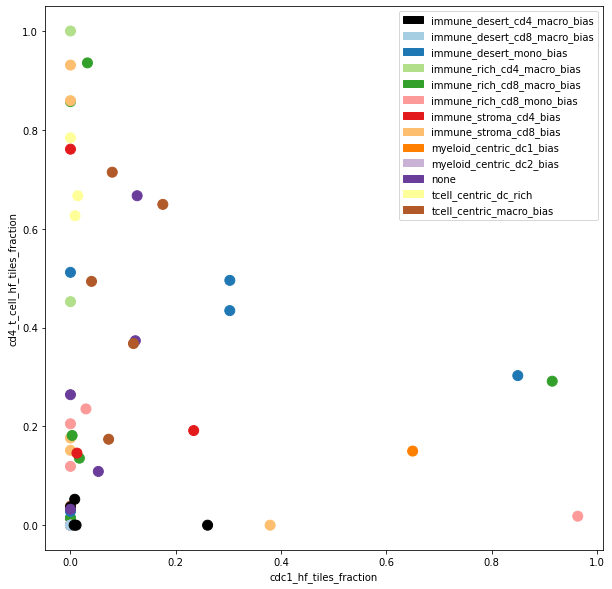

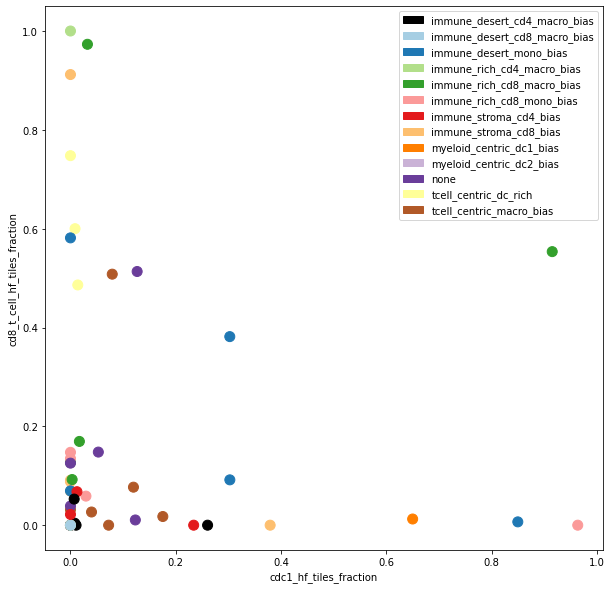

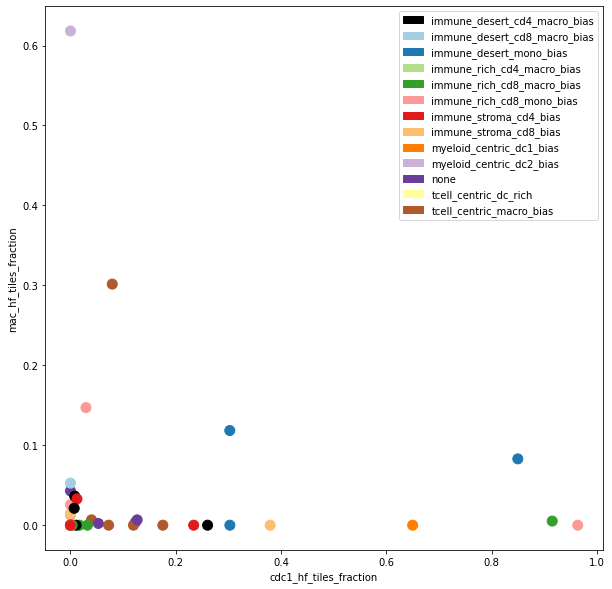

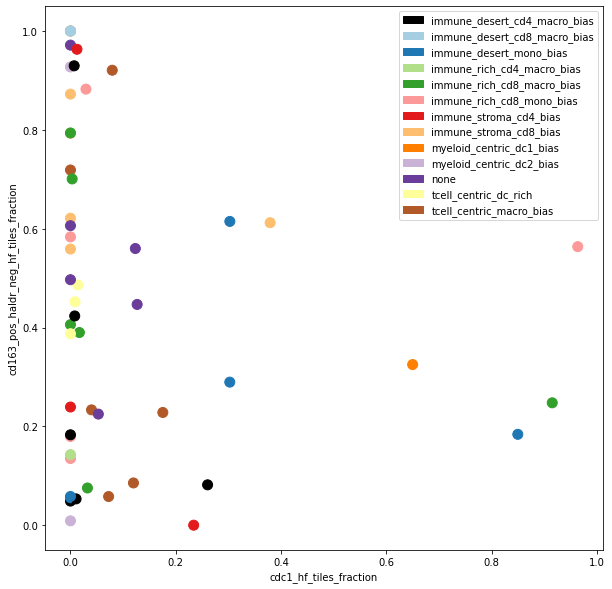

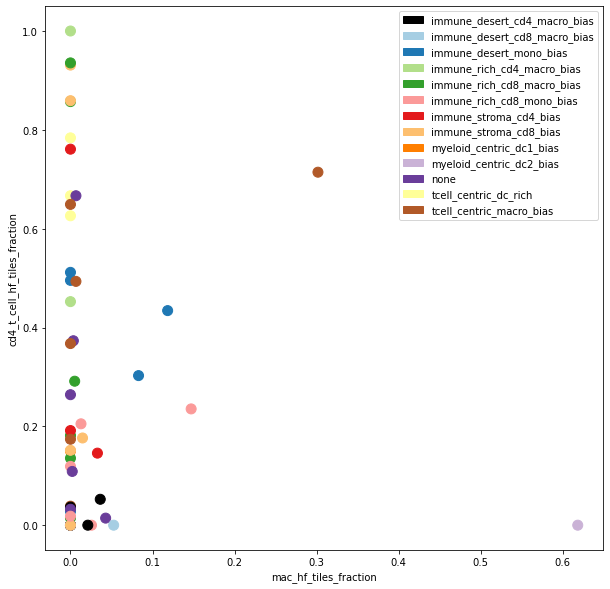

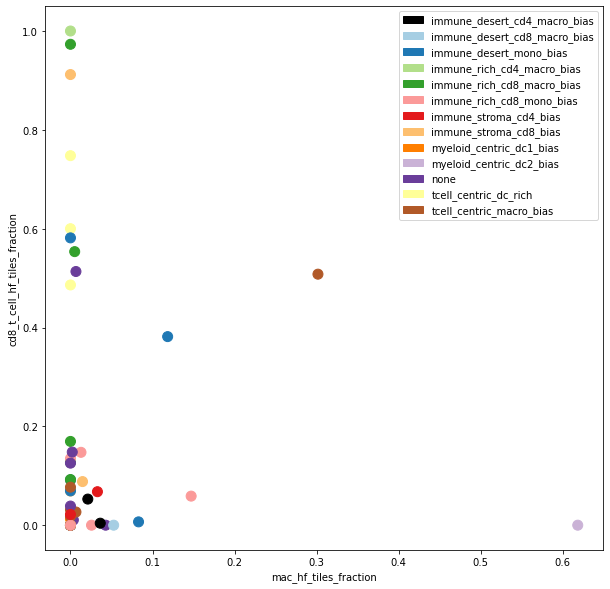

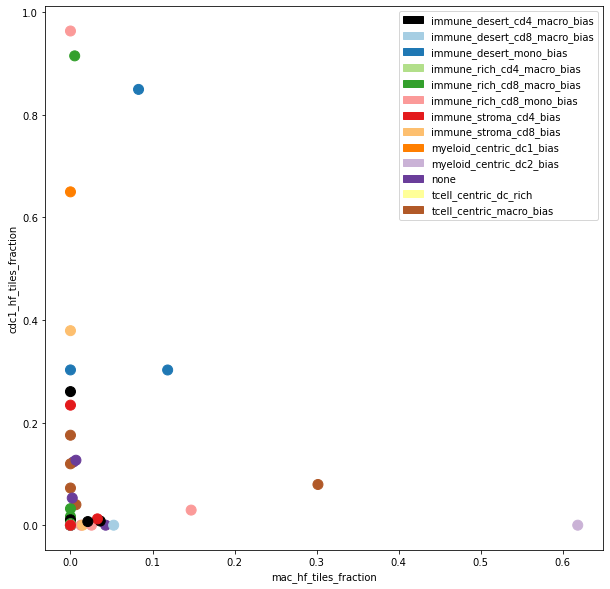

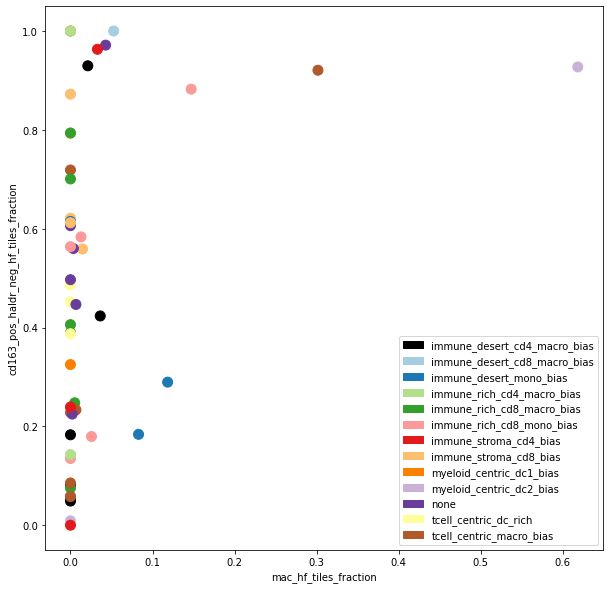

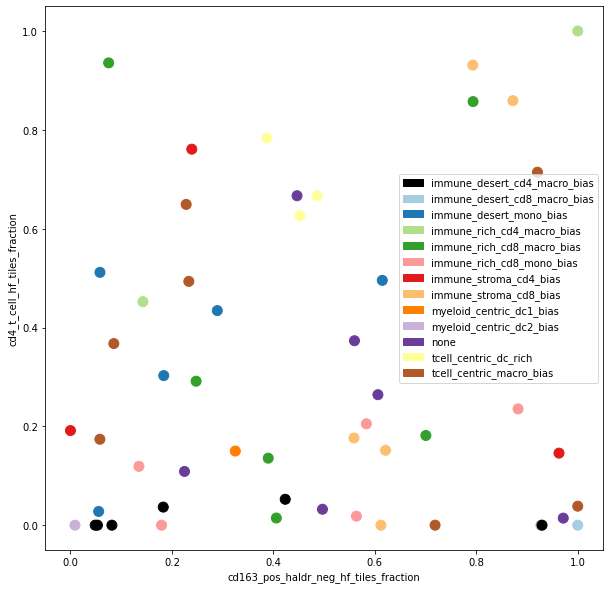

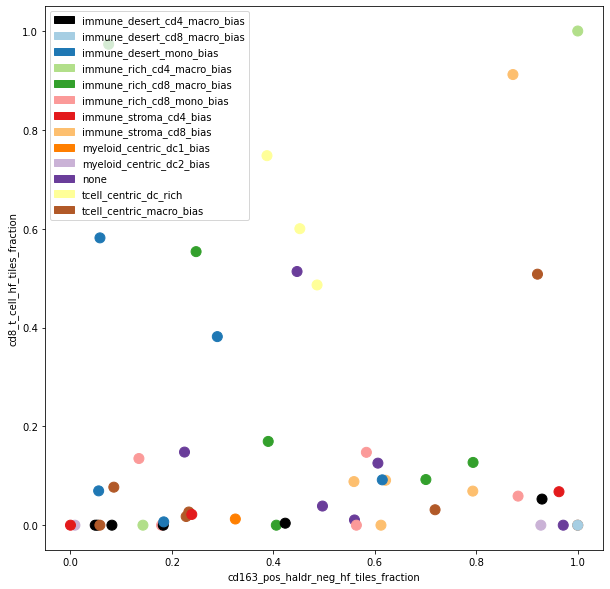

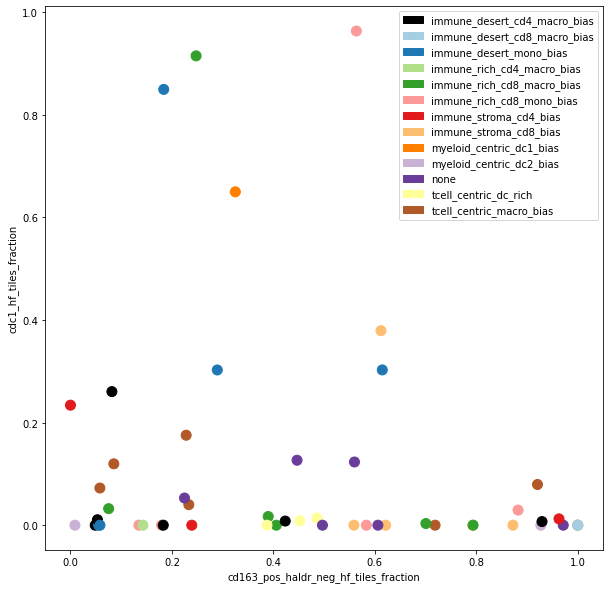

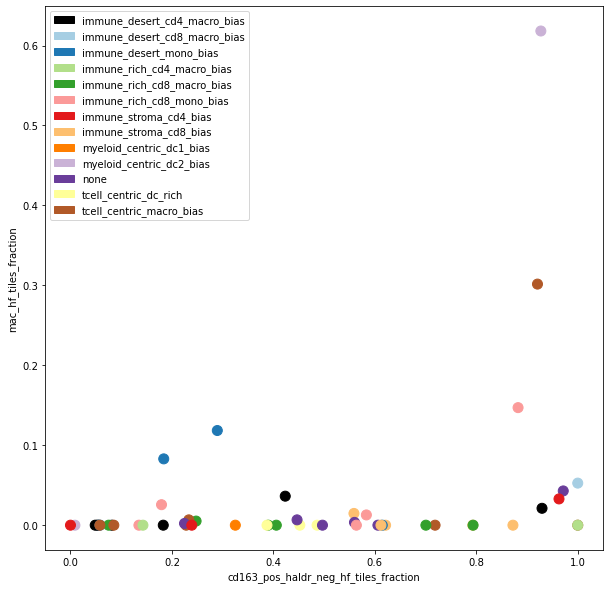

In [191]:
for ct1 in cell_types:
    for ct2 in cell_types:
        
        if ct1==ct2: continue
        feature1 = ct1 + "_hf_tiles_fraction"
        feature2 = ct2 + "_hf_tiles_fraction"
        
        double_feature_scatter_plot(df, feature1, feature2, colors, savedir, log=False)
        

In [225]:

def plot_single_cell_type_feature(df, feature, savedir,colors=colors, plot_type='sample',ylim=[0,1]):

    fig = plt.figure(figsize=(15,10))
    fig.patch.set_facecolor('white')


    x = 0
    bar_width = 0.25
    arch_gap = 0.5
    xtick_labels = []
    xtick_pos = []

    for i, arch in enumerate(archetypes):

        data = df[df['archetype']==arch]

        nsamples = len(data)
        values = data[["sample",feature]].sort_values(by=feature,ascending=True)

        color = colors[i]

        if plot_type=='sample':

            for row in values.iterrows(): 

                name = row[1]['sample']
                val = row[1][feature]

                xtick_labels.append(name)
                plt.bar(x=x, height=val, width=bar_width, color=color)
                xtick_pos.append(x)
                x += bar_width


        elif plot_type == 'archetype':

            xtick_labels.append(arch)
            xtick_pos.append(x)

            plt.boxplot(x=values[feature].values, positions=[x])

        x+=arch_gap

    plt.xticks(xtick_pos, xtick_labels, rotation='vertical')

    if plot_type == 'sample':
        legend_bars = []

        for i in np.arange(len(archetypes)):
            legend_bars.append(mpatches.Patch(color=colors[i], label=archetypes[i]))

        plt.legend(handles=legend_bars)

    plt.ylabel(feature,size=15)
    plt.ylim(ylim)
    
    figpath = Path(savedir, feature + "_" + plot_type + ".png")

    plt.savefig(figpath,
            facecolor=fig.get_facecolor(),
            bbox_inches='tight',
            transparent=False)
    #plt.close('all')

In [226]:
def double_feature_scatter_plot(df, feature1, feature2, colors, savepath, log=True):
    
    data = df[['sample', 'archetype',feature1,feature2]]
    
    fig = plt.figure(figsize=(10,10))
    
    fig.patch.set_facecolor('white')
    
    color_dict = {}
    archetypes = np.unique(data['archetype'])
    for i, archetype in enumerate(archetypes):
        color_dict[archetype] = colors[i]
    if log:
        plt.scatter(np.log10(data[feature1]), np.log10(data[feature2]), color=data['archetype'].map(color_dict), s=100)
        plt.xlabel('log(' + feature1 + ')')
        plt.ylabel('log(' + feature2 + ')')
    else:
        plt.scatter(data[feature1], data[feature2], color=data['archetype'].map(color_dict), s=100)
        plt.xlabel(feature1)
        plt.ylabel(feature2)
    
    legend_bars = []

    for i in np.arange(len(archetypes)):
        legend_bars.append(mpatches.Patch(color=colors[i], label=archetypes[i]))
    plt.legend(handles=legend_bars)
    figpath = Path(savedir, feature1 + "_vs_" + feature2 + ".png")
    
    plt.savefig(figpath,
            facecolor=fig.get_facecolor(),
            bbox_inches='tight',
            transparent=False)
    


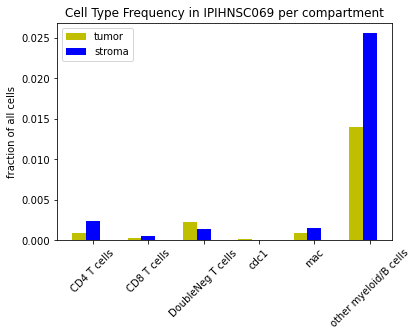

In [11]:
total_cells = len(df)

tumor = []
stroma = []

for ct in cell_types:

    n_in_tumor = sum((df['cell_type']==ct) & (df['in_tumor']==1))
    tum_frac = n_in_tumor/total_cells
    tumor.append(tum_frac)
    
    n_in_stroma = sum((df['cell_type']==ct) & (df['in_tumor']==0))
    stromal_frac = n_in_stroma/total_cells
    stroma.append(stromal_frac)

data = [tumor, stroma]

fig = plt.subplots()
bar_width = 0.25

br1 = np.arange(len(cell_types))
br2 = [x + bar_width for x in br1]

plt.bar(br1,data[0], color='y', width=0.25,label='tumor')
plt.bar(br2,data[1], color='b', width=0.25,label='stroma')

plt.ylabel('fraction of all cells')
plt.legend(['tumor', 'stroma'])
plt.xticks([r + bar_width for r in range(len(cell_types))],
        cell_types)
plt.title(f'Cell Type Frequency in {sample} per compartment')
plt.xticks(rotation=45)
plt.savefig(Path(savedir,sample,f"{sample}_frequency_tumor.png"),bbox_inches='tight',facecolor=[1,1,1])

In [227]:
df = pd.read_csv("/home/austin/data/IPI/tiled_frequency_results/summarized_data.csv")
savedir = Path("/home/austin/data/IPI/tiled_frequency_results/summary_figures")

if not savedir.exists():
    savedir.mkdir()
df = df.drop(['Unnamed: 0'], axis=1)

archetypes = np.unique(df['archetype'])
arch_df = df[['sample','archetype']]

In [228]:
cell_types = ['cd4_t_cell',
              'cd8_t_cell',
              'cdc1',
              'mac',
              'cd163_pos_haldr_neg']

In [204]:
datadir = Path("/home/austin/data/IPI/tiled_frequency_results/")
data_list = []
for d in datadir.iterdir():
    if not (d.name.startswith('IPI') and d.is_dir()): continue
    sample_name = d.name
    ws = 100
    
    data_filepath = Path(d, sample_name + "_" + str(ws)+"_tile_data.csv")
    
    try:
        df = pd.read_csv(data_filepath)
        df['sample'] = [sample_name]*len(df)
        data_list.append(df)
    except FileNotFoundError:
        pass

fraction_cols = ['fraction_' + ct for ct in cell_types if ct not in ['other','other_myeloid_and_b_cells']]
df = pd.concat(data_list)
data = (df[fraction_cols]-df[fraction_cols].mean())/df[fraction_cols].std()


In [207]:
from sklearn.cluster import KMeans
import seaborn as sns
X = data.values
kmeans = KMeans(n_clusters=6).fit(X)

centers = kmeans.cluster_centers_

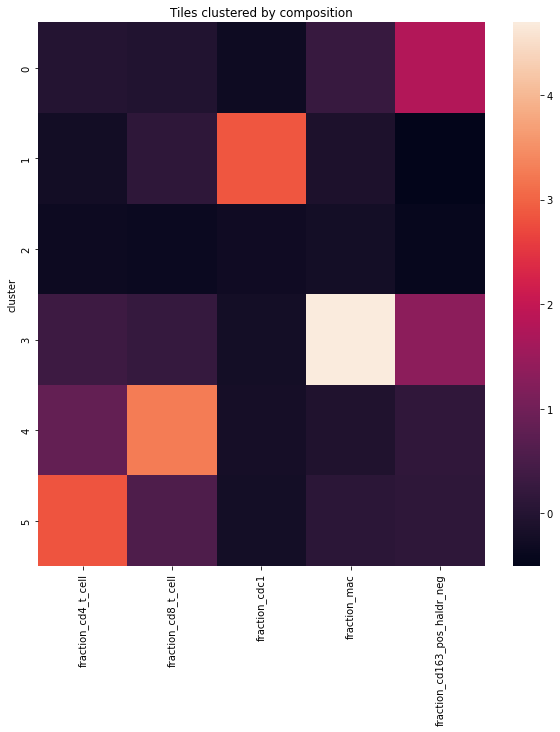

In [208]:
fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('white')
plot = sns.heatmap(centers)
plot.set_xticklabels(fraction_cols, rotation=90)
plot.set(ylabel='cluster')
plt.title('Tiles clustered by composition')

plt.savefig(Path("/home/austin/data/IPI/tiled_frequency_results/summary_figures/heatmap_tile_clusters.png"),bbox_inches='tight',transparent=False)

In [209]:
df['labels'] = kmeans.labels_

In [210]:
tile_clusters = {}
arch_dict = {}

for sample in np.unique(df['sample']):
    tile_clusters[sample] = []
    sample_data = df[df['sample']==sample]
    counts = sample_data['labels'].value_counts()
    arch_dict[sample] = arch_df[arch_df['sample']==sample]['archetype'].values[0]
    for k in np.unique(kmeans.labels_):
        try:
            tile_clusters[sample].append(counts[k])
        except KeyError:
            tile_clusters[sample].append(0)
            
for k,v in tile_clusters.items():
    tile_clusters[k] = v/np.sum(v)

In [211]:
colors = ['#000000','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']
print(len(colors))

13


In [212]:
df = pd.DataFrame(tile_clusters).transpose()
arch_df = arch_df.set_index('sample')
arch_df = arch_df.sort_values('archetype')

In [213]:
df = df.reindex(arch_df.index)

In [214]:
arch_df['archetype'].values

array(['immune_desert_cd4_macro_bias', 'immune_desert_cd4_macro_bias',
       'immune_desert_cd4_macro_bias', 'immune_desert_cd4_macro_bias',
       'immune_desert_cd4_macro_bias', 'immune_desert_cd4_macro_bias',
       'immune_desert_cd8_macro_bias', 'immune_desert_mono_bias',
       'immune_desert_mono_bias', 'immune_desert_mono_bias',
       'immune_desert_mono_bias', 'immune_desert_mono_bias',
       'immune_rich_cd4_macro_bias', 'immune_rich_cd4_macro_bias',
       'immune_rich_cd4_macro_bias', 'immune_rich_cd4_macro_bias',
       'immune_rich_cd8_macro_bias', 'immune_rich_cd8_macro_bias',
       'immune_rich_cd8_macro_bias', 'immune_rich_cd8_macro_bias',
       'immune_rich_cd8_macro_bias', 'immune_rich_cd8_macro_bias',
       'immune_rich_cd8_mono_bias', 'immune_rich_cd8_mono_bias',
       'immune_rich_cd8_mono_bias', 'immune_rich_cd8_mono_bias',
       'immune_rich_cd8_mono_bias', 'immune_stroma_cd4_bias',
       'immune_stroma_cd4_bias', 'immune_stroma_cd4_bias',
       'immun

/tmp/ipykernel_564039/2347224464.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(arch_df['archetype'].values)


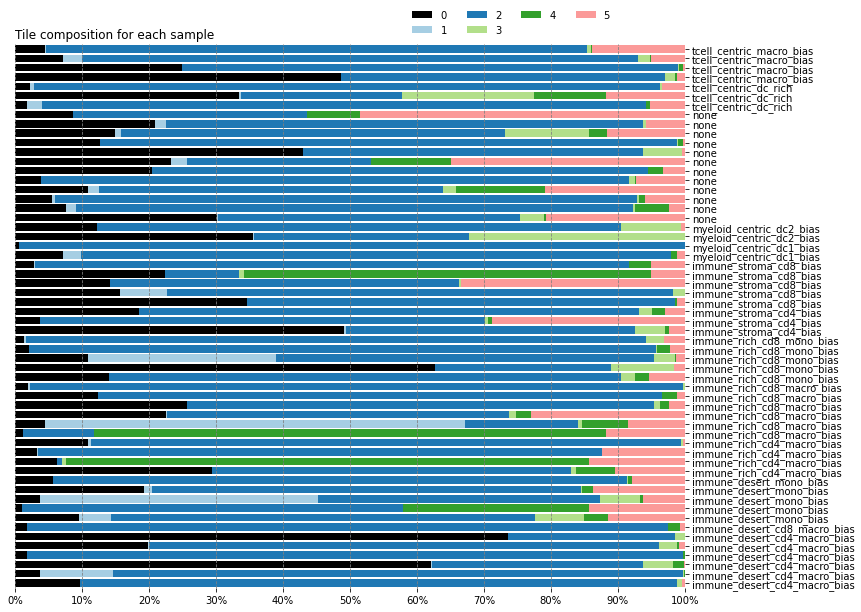

In [221]:

# variables
labels = [str(k) for k in np.arange(12)]
title='Tile composition for each sample'

fields = df.columns.tolist()

# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
fig.patch.set_facecolor('white')
# plot bars
left = len(df) * [0]
for idx, name in enumerate(fields):
    plt.barh(df.index, df[name], left = left, color=colors[idx])
    left = left + df[name]
# title and subtitle
plt.title(title, loc='left')
plt.text(0, ax.get_yticks()[-1] + 0.75, subtitle)
# legend
plt.legend(labels, bbox_to_anchor=([0.58, 1, 0, 0]), ncol=4, frameon=False)
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# format x ticks
xticks = np.arange(0,1.1,0.1)
xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
plt.xticks(xticks, xlabels)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_yticklabels(arch_df['archetype'].values)
plt.savefig(Path("/home/austin/data/IPI/tiled_frequency_results/summary_figures/tile_clusers_per_sample_archs.png"),
           bbox_inches='tight',
           transparent=False)
